Steam stripping ethanol from water (equimolar overflow)
Basis: F = 1 mol feed
xF = 0.033000
Recovery to overhead vapor = 0.9900 of ethanol in feed
Bottoms ethanol (by recovery + L≈F assumption): xB = 0.00033000

(a) Minimum steam at infinite steps (graphical)
Vmin = 0.12100000 mol vapor per mol feed
Smin/F = 0.12100000 mol steam per mol feed
Overhead vapor ethanol at Vmin (from recovery): y_top = 0.270000

(b) Using twice minimum steam
V = 2*Vmin = 0.24200000 mol vapor per mol feed
S/F = 0.24200000 mol steam per mol feed
Overhead vapor ethanol y_top = 0.135000
Bottoms ethanol xB = 0.00033000
Theoretical steps required = 4.991


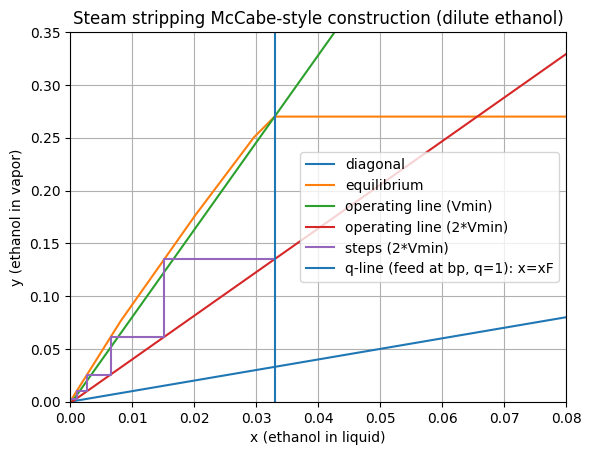

In [1]:
# notebooks/26.4_9.py

import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, "..")

from bank.Distillation.distillation_mccabe_thiele_xy_base import XYEquilibrium

# ============================================================
# Given
# ============================================================
# Feed basis
F = 1.0                 # mol feed (basis)
xF = 0.033              # ethanol in liquid feed (boiling point => saturated liquid)

# Recovery requirement
frac_alc_to_overhead = 0.99  # 99% of ethanol in feed leaves in overhead vapor

# Equilibrium data (ethanol mole fraction at 1 atm)
x_eq = [0.0000, 0.0080, 0.0200, 0.0296, 0.0330]
y_eq = [0.0000, 0.0750, 0.1750, 0.2500, 0.2700]
eq = XYEquilibrium(x=x_eq, y=y_eq)

# Assumption consistent with standard steam-stripping problems + equimolar overflow:
# - Downflowing liquid rate L ≈ F (constant)
# - Upflowing vapor rate V ≈ S (steam rate, constant)
L = F

# Bottoms alcohol: remaining 1% in bottoms liquid.
# With liquid rate ≈ F, bottoms composition is fixed by recovery:
xB = (1.0 - frac_alc_to_overhead) * xF  # because bottoms moles ~ F
# (If you later include condensation/extra water, this is the first thing to generalize.)
# Steam enters alcohol-free:
y_in_bottom = 0.0

# ============================================================
# Helper functions
# ============================================================
def y_operating(x: float, V: float) -> float:
    """
    Stripping-section operating line with bottom boundary y=0 at x=xB:
      y = (L/V) (x - xB)
    """
    return (L / V) * (x - xB)


def y_top_from_recovery(V: float) -> float:
    """
    Overhead vapor ethanol from recovery:
      V*y_top = 0.99 * F*xF
    """
    return (frac_alc_to_overhead * F * xF) / V


def compute_Vmin_graphical(n_scan: int = 5000) -> float:
    """
    For q=1 liquid feed entering top, stripping-only section, y_in_bottom=0.

    Feasibility requirement for the stripping operating line (must lie below equilibrium):
      y_operating(x;V) <= y_eq(x) for all x in [xB, xF]

    With y_operating(x;V) = (L/V)(x-xB),
    the minimum V is the smallest V that satisfies the inequality.

    Rearranged (for y_eq(x) > 0):
      V >= L (x - xB) / y_eq(x)

    But y_top is ALSO linked to V by recovery; that is already embedded because
    the line definition uses (L/V) and bottom boundary (xB,0). No separate y_top needed here.
    """
    xs = np.linspace(xB + 1e-12, xF, n_scan)
    req = []
    for x in xs:
        ye = eq.y_of_x(float(x))
        if ye <= 1e-14:
            continue
        req.append(L * (x - xB) / ye)
    if not req:
        raise ValueError("Equilibrium y values too small in interval; check data.")
    return float(max(req))


def step_off_stripping(V: float, max_steps: int = 500) -> dict:
    """
    McCabe-type stepping for stripping-only section, done from the TOP downward:

    Known:
      top liquid entering = xF
      overhead vapor leaving = y1 (from recovery and V)
      operating line: y = (L/V)(x - xB)

    Algorithm:
      start at point (xF, y1) ON OPERATING LINE (top plate material balance boundary)
      repeat:
        1) horizontal to equilibrium: find x_eq s.t. y_eq(x_eq) = y_curr
        2) vertical to operating line: y_next = y_operating(x_eq, V)
      stop when x_eq <= xB.

    Returns:
      N_steps: number of horizontal-to-equilibrium moves (fractional last via linear x interpolation)
      points: polyline points for plotting
      y_top, x_bottom
    """
    y1 = y_top_from_recovery(V)
    if y1 < 0 or y1 > 1:
        raise ValueError("Computed y_top outside [0,1]. Increase V or check recovery basis.")

    pts = [(xF, y1)]
    y_curr = y1

    xeq_list = []

    for n in range(1, max_steps + 1):
        xeq = eq.x_of_y(float(y_curr))
        xeq_list.append(xeq)
        pts.append((xeq, y_curr))

        if xeq <= xB + 1e-12:
            # fractional last step based on last two xeq values
            if len(xeq_list) < 2:
                N = float(n)
            else:
                x_prev = xeq_list[-2]
                x_now = xeq_list[-1]
                if abs(x_prev - x_now) < 1e-14:
                    frac = 1.0
                else:
                    frac = (x_prev - xB) / (x_prev - x_now)
                    frac = max(0.0, min(1.0, frac))
                N = (n - 1) + frac
            return {
                "N_steps": N,
                "points": pts,
                "y_top": y1,
                "x_bottom": xB,
            }

        y_next = y_operating(float(xeq), V)
        y_next = max(0.0, min(1.0, y_next))
        pts.append((xeq, y_next))
        y_curr = y_next

    raise RuntimeError("Exceeded max_steps; increase max_steps or check feasibility.")


# ============================================================
# (a) Infinite steps -> minimum steam Vmin/F
# ============================================================
Vmin = compute_Vmin_graphical()
Smin_per_F = Vmin / F

# also compute y_top at Vmin (implied by recovery)
y_top_min = y_top_from_recovery(Vmin)

# ============================================================
# (b) Twice minimum steam
# ============================================================
V2 = 2.0 * Vmin
S2_per_F = V2 / F

res2 = step_off_stripping(V2)
N2 = res2["N_steps"]
y_top_2 = res2["y_top"]
x_bottom = res2["x_bottom"]

# ============================================================
# Print results
# ============================================================
print("============================================================")
print("Steam stripping ethanol from water (equimolar overflow)")
print("============================================================")
print(f"Basis: F = {F:.6g} mol feed")
print(f"xF = {xF:.6f}")
print(f"Recovery to overhead vapor = {frac_alc_to_overhead:.4f} of ethanol in feed")
print(f"Bottoms ethanol (by recovery + L≈F assumption): xB = {xB:.8f}")

print("\n(a) Minimum steam at infinite steps (graphical)")
print(f"Vmin = {Vmin:.8f} mol vapor per mol feed")
print(f"Smin/F = {Smin_per_F:.8f} mol steam per mol feed")
print(f"Overhead vapor ethanol at Vmin (from recovery): y_top = {y_top_min:.6f}")

print("\n(b) Using twice minimum steam")
print(f"V = 2*Vmin = {V2:.8f} mol vapor per mol feed")
print(f"S/F = {S2_per_F:.8f} mol steam per mol feed")
print(f"Overhead vapor ethanol y_top = {y_top_2:.6f}")
print(f"Bottoms ethanol xB = {x_bottom:.8f}")
print(f"Theoretical steps required = {N2:.3f}")

# ============================================================
# Optional plots: equilibrium, operating lines, stepping
# ============================================================
xs = np.linspace(0, max(0.08, xF * 1.2), 500)  # zoom near dilute region
xs = np.clip(xs, 0, 1)
yeq = np.array([eq.y_of_x(float(x)) for x in xs])

# operating lines
yop_min = np.array([y_operating(float(x), Vmin) for x in xs])
yop_2 = np.array([y_operating(float(x), V2) for x in xs])

pts2 = np.array(res2["points"], dtype=float)

plt.figure()
plt.plot(xs, xs, label="diagonal")
plt.plot(xs, yeq, label="equilibrium")
plt.plot(xs, yop_min, label="operating line (Vmin)")
plt.plot(xs, yop_2, label="operating line (2*Vmin)")
plt.plot(pts2[:, 0], pts2[:, 1], linewidth=1.5, label="steps (2*Vmin)")
plt.axvline(x=xF, label="q-line (feed at bp, q=1): x=xF")
plt.xlim(0, max(0.08, xF * 1.2))
plt.ylim(0, 0.35)
plt.grid(True)
plt.xlabel("x (ethanol in liquid)")
plt.ylabel("y (ethanol in vapor)")
plt.title("Steam stripping McCabe-style construction (dilute ethanol)")
plt.legend()
plt.show()